<a href="https://colab.research.google.com/github/dragonheat123/fashion_mnist/blob/master/max_pool_long_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary libraries**

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.3.0'

**Loading in data for the fashion-MNIST dataset**

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Checking the size and values of the data:

In [ ]:
print(np.shape(train_images),np.shape(train_labels),np.shape(test_images),np.shape(test_labels))

print(np.min(train_images),np.max(train_images))
print(np.min(train_labels),np.max(train_labels))
print(np.min(test_images),np.max(test_images))
print(np.min(test_labels),np.max(test_labels))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
0 255
0 9
0 255
0 9


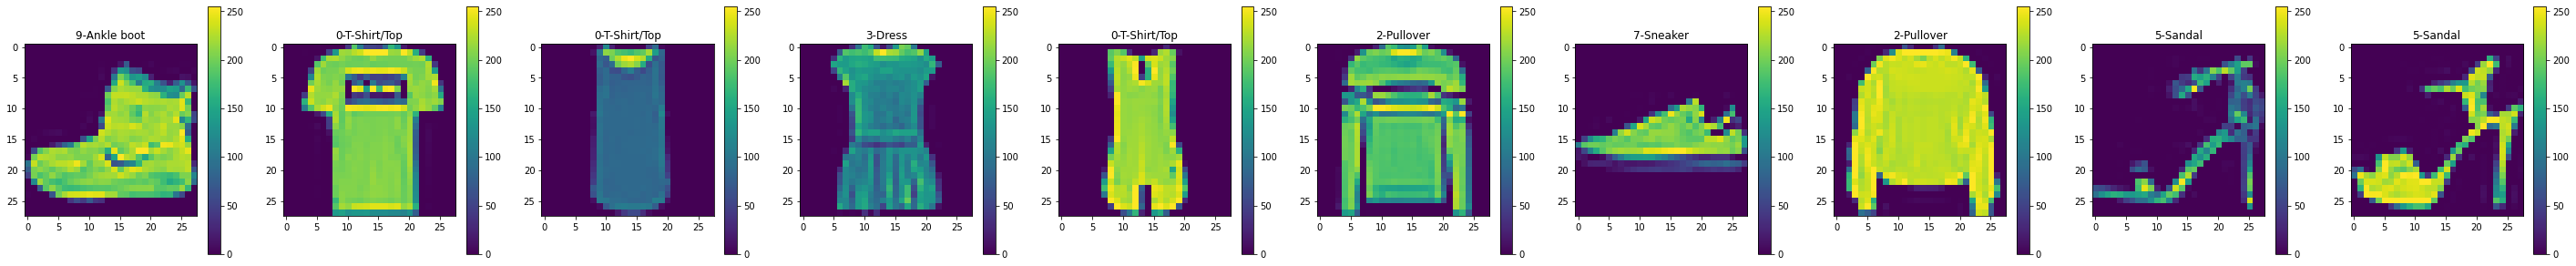

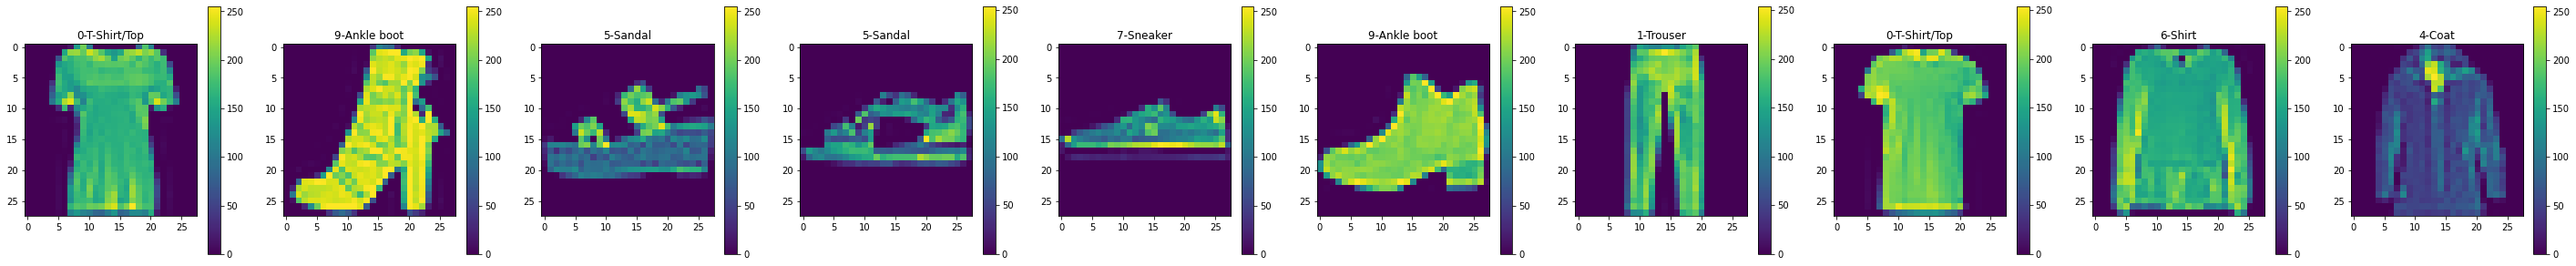

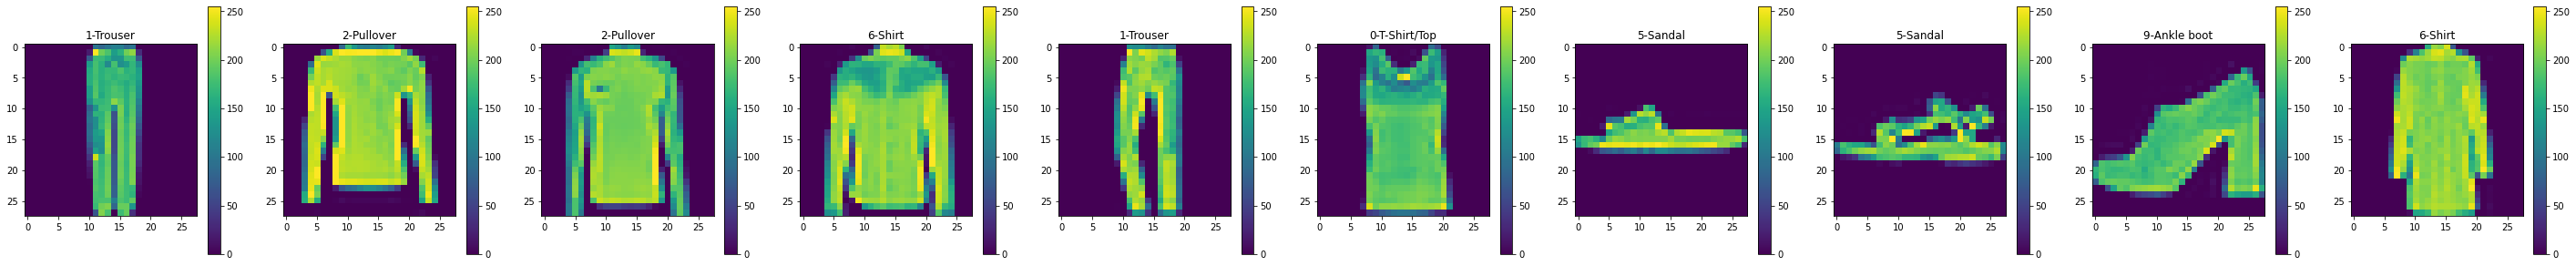

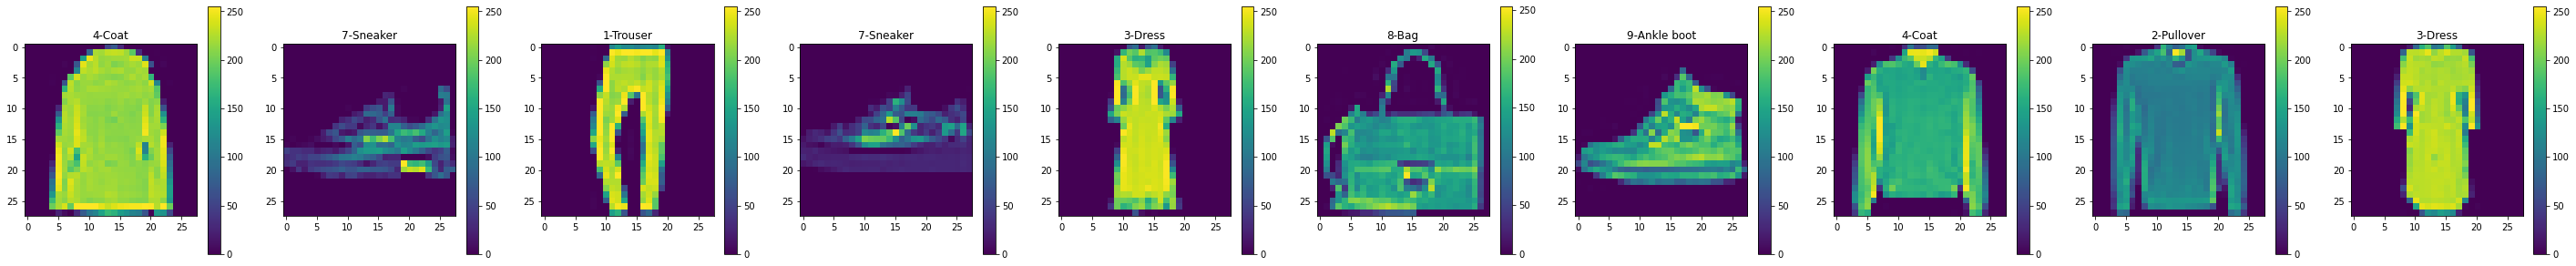

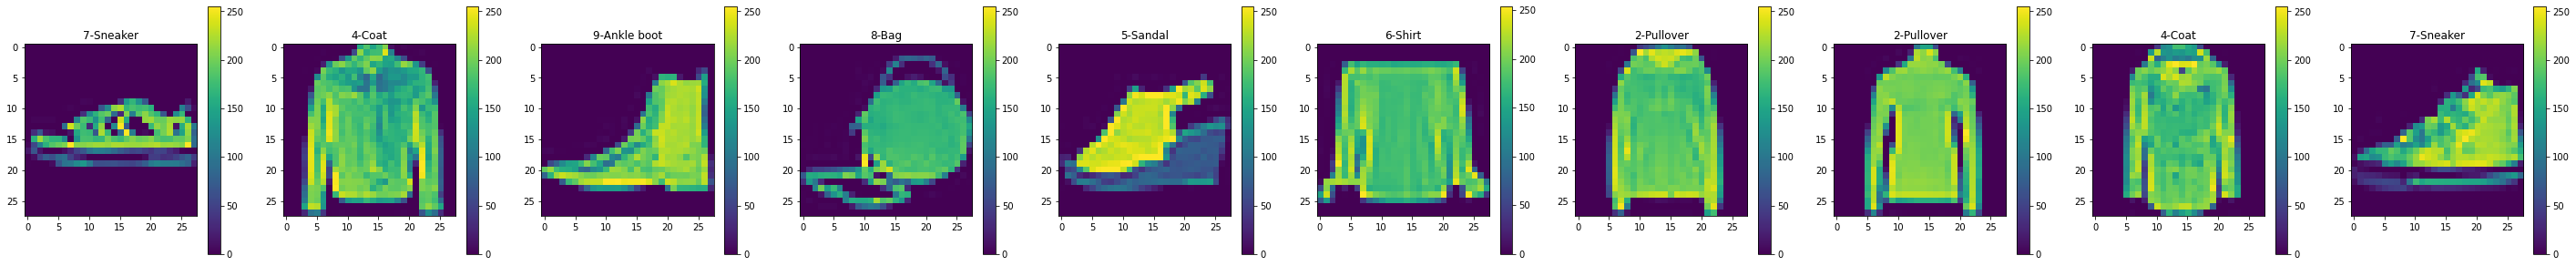

In [ ]:
labels_text = ["T-Shirt/Top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


plt.figure(figsize=(50,5))
for i in range(0,10):
  plt.subplot(1,10,i+1)
  plt.title(str(train_labels[i]) + "-" + str(labels_text[train_labels[i]]))
  plt.imshow(train_images[i])
  plt.colorbar()

plt.figure(figsize=(50,5))
for i in range(10,20):
  plt.subplot(1,10,i-10+1)
  plt.title(str(train_labels[i]) + "-" + str(labels_text[train_labels[i]]))
  plt.imshow(train_images[i])
  plt.colorbar()

plt.figure(figsize=(50,5))
for i in range(1000,1010):
  plt.subplot(1,10,i-1000+1)
  plt.title(str(train_labels[i]) + "-" + str(labels_text[train_labels[i]]))
  plt.imshow(train_images[i])
  plt.colorbar()

plt.figure(figsize=(50,5))
for i in range(2000,2010):
  plt.subplot(1,10,i-2000+1)
  plt.title(str(train_labels[i]) + "-" + str(labels_text[train_labels[i]]))
  plt.imshow(train_images[i])
  plt.colorbar()

plt.figure(figsize=(50,5))
for i in range(5500,5510):
  plt.subplot(1,10,i-5500+1)
  plt.title(str(train_labels[i]) + "-" + str(labels_text[train_labels[i]]))
  plt.imshow(train_images[i])
  plt.colorbar()

Visually exploring the data.
It seems like the images are well focused on the item, with straight and centered shots, and items are always the right side up. 

*   One thing to note is that there seem to be alot more tops and shoes compared to the rest of the other classes, so let's check the class distribution later
*   The other thing is that the outline for each class of images is clear, but the interior grayscale intensity is changing -- > so we need to design within our CNN a component to deal with it (batch norm might help)
*   The images seems to be well centered and seems to be the right way up all the time. So just in case, to account for images that might be flipped horizontally, and slightly rotated/translated, we perform image augmentation to the data used for training
*   The images values will need to be rescale to 0-1 for more efficient learning


**Checking class distribution**

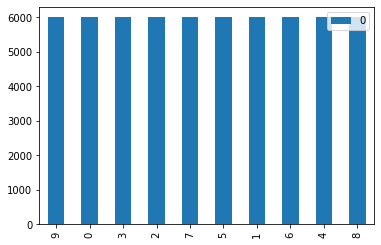

In [ ]:
label_dist = list(train_labels)
label_dist = [str(x) for x in label_dist]
import pandas
from collections import Counter
letter_counts = Counter(label_dist)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')


The class distribution seems to be even, which is a good sign. Otherwise we will have to do resampling to even out the classes, or customize the loss function of our model, to ensure learning is proper.

In [ ]:
train_images_n = train_images/255
test_images_n = test_images/255

train_images_n = train_images_n.reshape(len(train_labels),28,28,1)
test_images_n = test_images_n.reshape(len(test_labels),28,28,1)

#####splitting training set into a train set and validation set for image augmentation
from sklearn.model_selection import train_test_split
train_images_a, val_images_a, train_labels_a, val_labels_a = train_test_split(train_images_n, train_labels, test_size=0.2, random_state=1)


We normalize the images and then we split the training set into train and validation set for image augmentation.

**Augmenting the dataset with horizontal flips | +-5% translation | +-5 deg rotations | [0.95-1.05] zoom**

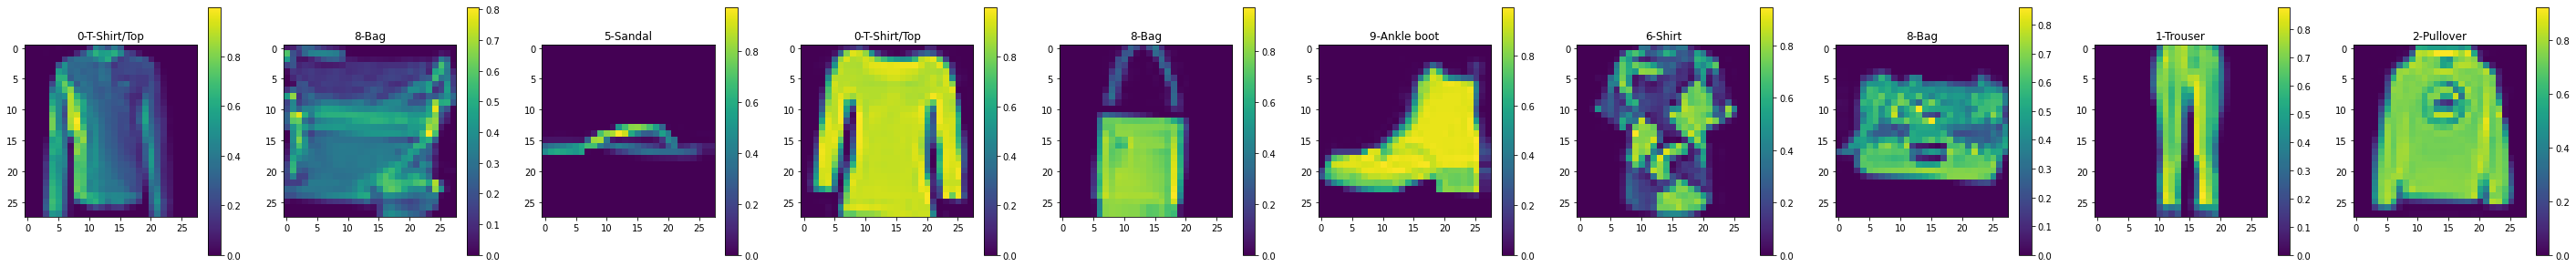

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

train_transformations = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')

vis_generator = train_transformations.flow(train_images_n,train_labels,batch_size=1)
train_generator = train_transformations.flow(train_images_a,train_labels_a,batch_size=512)
val_generator = train_transformations.flow(val_images_a,val_labels_a,batch_size=512)


######visualization of the augmentations
plt.figure(figsize=(50,5))
for i in range(0,10):
  v = vis_generator.next()
  img = v[0][0].reshape([28,28])
  plt.subplot(1,10,i+1)
  plt.title(str(v[1][0]) + "-" + str(labels_text[v[1][0]]))
  plt.imshow(img)
  plt.colorbar()

Image augmentation for the training data helps the CNN model to become more resillent to image rotation, tranlation, zooming, and shear effects that could affect an input image

**CNN Design**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Concatenate, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

input_layer = keras.Input(shape=(28,28,1))
bn = BatchNormalization()(input_layer)                                          #batch normalization to prevent the network from being fixated on a certain feature, by keeping the weights of the network from going too extreme
conv1 = Conv2D(filters=128,kernel_size=3,activation='relu')(bn)                 #large number of initial (3x3) filter to gather features for the model
do_1 = keras.layers.Dropout(0.1)(conv1)                                         #dropout between image layers to prevent overfitting to the training dataset
conv2 = Conv2D(filters=64,kernel_size=3,activation='relu')(do_1)                #second layer of filter to obtain higher level features
mp1 = MaxPooling2D(pool_size=(3,3))(conv2)                                      #combine both maxpooling + averagepooling to capture both sharp features (especially the edge of the images) and smooth out softer features (like logos in shirt)
ap1 = AveragePooling2D(pool_size=(3,3))(conv2)
conc = Concatenate()([mp1,ap1])
flat1 = Flatten()(conc)                                                         #convert output of filters into single feature vector
do_2 = keras.layers.Dropout(0.1)(flat1)                                         #again dropout to prevent overfitting
dense1 = Dense(128,activation='relu')(do_2)                                     #dense layer to evaluate the feature vector and obtain accurate feature representation
output_layer = Dense(10, activation='softmax')(dense1)                          #softmax for output for catergorical classification

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 128)  1280        batch_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 26, 26, 128)  0           conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
### using sparsecategoricalcrossentropy loss because labels are not one-hot encoded but are integers instead (onehot uses categorical loss)  

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
### using early stopping to stop the training once the validation accuracy plateau, to ensure that the model will not be overfitting, 
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True)


In [ ]:
### since the imagedatagenerator shuffles samples when outputting batches, the model is sort of cross-validated
### small batch-size so model will gradients gradually and learn according to the features of each batch
history = model.fit(train_generator,validation_data=val_generator, epochs=800, callbacks=[es], batch_size=512, shuffle=True) 

Epoch 1/800
94/94 [==============================] - 25s 263ms/step - loss: 1.7773 - accuracy: 0.6850 - val_loss: 1.7654 - val_accuracy: 0.7145
Epoch 2/800
94/94 [==============================] - 24s 254ms/step - loss: 1.6709 - accuracy: 0.7915 - val_loss: 1.6955 - val_accuracy: 0.7738
Epoch 3/800
94/94 [==============================] - 24s 253ms/step - loss: 1.6426 - accuracy: 0.8193 - val_loss: 1.6486 - val_accuracy: 0.8145
Epoch 4/800
94/94 [==============================] - 24s 253ms/step - loss: 1.6245 - accuracy: 0.8370 - val_loss: 1.6152 - val_accuracy: 0.8489
Epoch 5/800
94/94 [==============================] - 24s 254ms/step - loss: 1.6163 - accuracy: 0.8453 - val_loss: 1.6020 - val_accuracy: 0.8613
Epoch 6/800
94/94 [==============================] - 24s 251ms/step - loss: 1.6057 - accuracy: 0.8557 - val_loss: 1.6064 - val_accuracy: 0.8543
Epoch 7/800
94/94 [==============================] - 24s 254ms/step - loss: 1.5979 - accuracy: 0.8639 - val_loss: 1.5959 - val_accuracy:

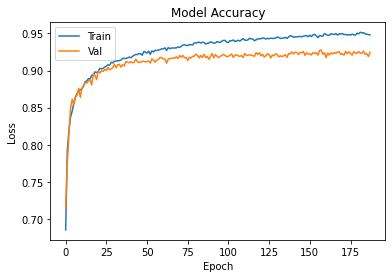

In [ ]:
plt.figure(3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

**Testing Accuracy**

In [ ]:
test_loss, test_acc = model.evaluate(test_images_n,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 1.5343 - accuracy: 0.9265

Test accuracy: 0.9265000224113464


**Error Analysis and Future Improvements**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 33.0, 'pred')

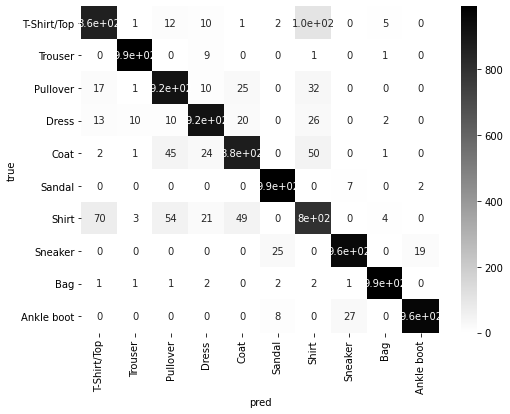

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels,np.argmax(model.predict(test_images_n),axis=1))

true_labels = [labels_text[x] for x in test_labels]
predicted_labels = [labels_text[x] for x in np.argmax(model.predict(test_images_n),axis=1)]

import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels_text, yticklabels=labels_text, cmap='binary',annot=True)
plt.ylabel('true')
plt.xlabel('pred')

The most common error is to mistake a shirt for a top and vice versa, and most errors are symmetrical. However, a perculiar one way error is to mistake a ankle-boot for a sneaker. Let's check out some images for the errors.

In [ ]:
labels_text

['T-Shirt/Top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

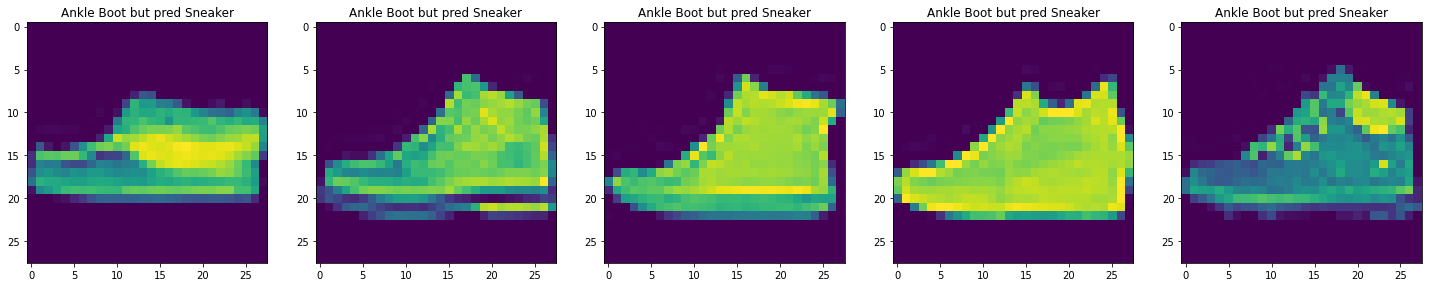

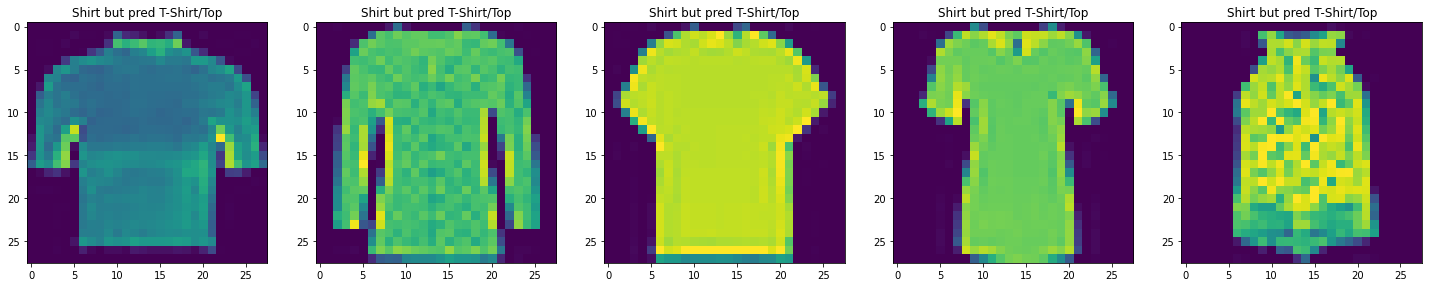

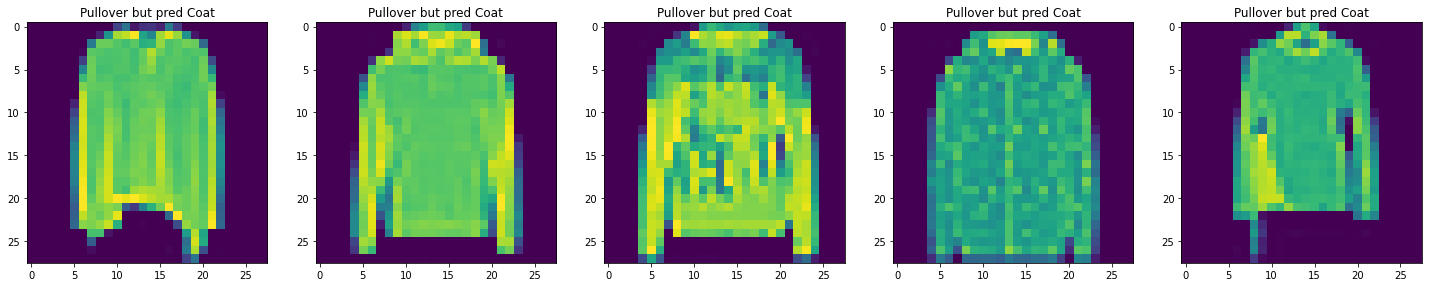

In [ ]:
ind = list(set(np.where(np.array(true_labels)=="Ankle boot")[0].tolist()).intersection(np.where(np.array(predicted_labels)=="Sneaker")[0].tolist()))
plt.figure(figsize=(25,5))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  plt.imshow(test_images[ind[i]])
  plt.title("Ankle Boot but pred Sneaker")


ind = list(set(np.where(np.array(true_labels)=="Shirt")[0].tolist()).intersection(np.where(np.array(predicted_labels)=="T-Shirt/Top")[0].tolist()))
plt.figure(figsize=(25,5))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  plt.imshow(test_images[ind[i]])
  plt.title("Shirt but pred T-Shirt/Top")


ind = list(set(np.where(np.array(true_labels)=="Pullover")[0].tolist()).intersection(np.where(np.array(predicted_labels)=="Coat")[0].tolist()))
plt.figure(figsize=(25,5))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  plt.imshow(test_images[ind[i]])
  plt.title("Pullover but pred Coat")
  


*    Some of these error pictures are really ambigous, not sure if a human will also classify it correctly.

*    Seems like the pictures in the test set are also focused nicely. In this case the image augmentation might add addtional noise that might distort the accuracy of the model, and might not be worth it to perform augmentation since it adds additional processing and training time. Some other augmentation methods could be tried out like random erasing of pixels. But the augmentation parameters will have carefully tuned to ensure there is minimal noise within the training data.

*    For future models, bayesian opt can be used to find the better hyperparameters that includes the number of filters, size of the the filters, dropout ratio and number of neurouns in the dense layer.

*    Also deeper convolutional networks architectures like ResNet with skip connections could be used to pick out more advanced features of classification. 

*    Hyperparameters optimization and increasing the depth of the network can have diminishing returns on the accuracy vs training complexity. 

**Testing effect for only a Maxpooling layer instead**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Concatenate, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

input_layera = keras.Input(shape=(28,28,1))
bna = BatchNormalization()(input_layera)                                          #batch normalization to prevent the network from being fixated on a certain feature, by keeping the weights of the network from going too extreme
conv1a = Conv2D(filters=128,kernel_size=3,activation='relu')(bna)                 #large number of initial (3x3) filter to gather features for the model
do_1a = keras.layers.Dropout(0.1)(conv1a)                                         #dropout between image layers to prevent overfitting to the training dataset
conv2a = Conv2D(filters=64,kernel_size=3,activation='relu')(do_1a)                #second layer of filter to obtain higher level features
mp1a = MaxPooling2D(pool_size=(3,3))(conv2a)                                      # maxpooling only
flat1a = Flatten()(mp1a)                                                         #convert output of filters into single feature vector
do_2a = keras.layers.Dropout(0.1)(flat1a)                                         #again dropout to prevent overfitting
dense1a = Dense(128,activation='relu')(do_2a)
bn2a = BatchNormalization()(dense1a)                                             #dense layer to evaluate the feature vector and obtain accurate feature representation
output_layera = Dense(10, activation='softmax')(bn2a)                          #softmax for output for catergorical classification

model2 = keras.Model(inputs=input_layera, outputs=output_layera)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
### using early stopping to stop the training once the validation accuracy plateau, to ensure that the model will not be overfitting, 
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True)
history = model2.fit(train_generator,validation_data=val_generator, epochs=800, callbacks=[es], batch_size=512, shuffle=True) 

Epoch 1/800
94/94 [==============================] - 24s 258ms/step - loss: 1.7157 - accuracy: 0.7615 - val_loss: 2.1949 - val_accuracy: 0.4693
Epoch 2/800
94/94 [==============================] - 24s 254ms/step - loss: 1.6226 - accuracy: 0.8490 - val_loss: 2.0306 - val_accuracy: 0.6597
Epoch 3/800
94/94 [==============================] - 24s 254ms/step - loss: 1.5999 - accuracy: 0.8688 - val_loss: 1.7477 - val_accuracy: 0.8257
Epoch 4/800
94/94 [==============================] - 24s 254ms/step - loss: 1.5877 - accuracy: 0.8799 - val_loss: 1.6201 - val_accuracy: 0.8645
Epoch 5/800
94/94 [==============================] - 24s 260ms/step - loss: 1.5792 - accuracy: 0.8874 - val_loss: 1.5823 - val_accuracy: 0.8855
Epoch 6/800
94/94 [==============================] - 24s 254ms/step - loss: 1.5727 - accuracy: 0.8933 - val_loss: 1.5808 - val_accuracy: 0.8891
Epoch 7/800
94/94 [==============================] - 24s 252ms/step - loss: 1.5686 - accuracy: 0.8971 - val_loss: 1.5827 - val_accuracy:

In [ ]:
test_loss, test_acc = model2.evaluate(test_images_n,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 1.5255 - accuracy: 0.9348

Test accuracy: 0.9348000288009644


Text(0.5, 33.0, 'pred')

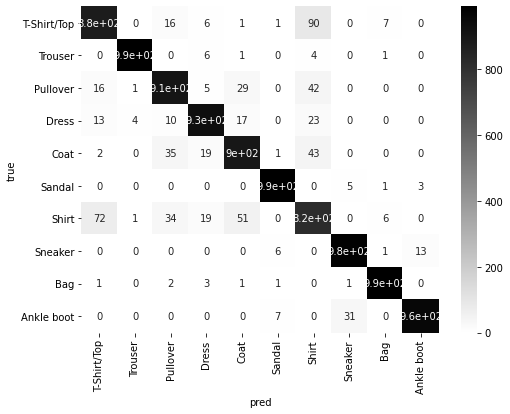

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels,np.argmax(model2.predict(test_images_n),axis=1))

import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels_text, yticklabels=labels_text, cmap='binary',annot=True)
plt.ylabel('true')
plt.xlabel('pred')